1、生成数据，(10000, 2)的数据点集，组成一个S形

shape of s: (10000, 2)


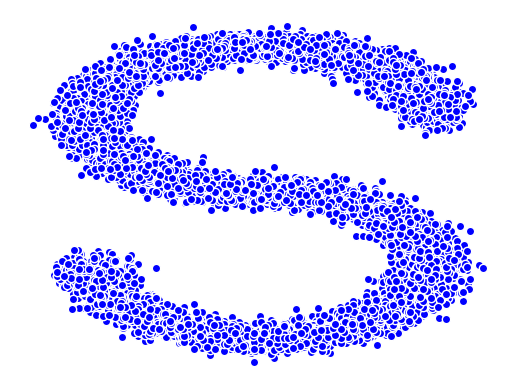

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve # 生成S形二维数据点 https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html
import torch

s_curve,_ = make_s_curve(10**4,noise=0.1) # 10000个数据点
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='blue',edgecolor='white');

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

2、确定超参数的值

betas: $\beta$

alphas: $\alpha = 1-\beta$

alphas_prod: $\overline{\alpha_t} = \prod_{s=1}^{t}\alpha_s$

alphas_prod_p: $1 + alphas\_prod[:-1] = \overline{\alpha_{t-1}}$

alphas_bar_sqrt: $\sqrt{\overline{\alpha_t}}$

one_minus_alphas_bar_log: $log(1-\overline{\alpha_t})$

one_minus_alphas_bar_sqrt: $\sqrt{1-\overline{\alpha_t}}$

In [2]:
num_steps = 100

#制定每一步的beta
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape # 确保所有列表长度一致
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


3、确定扩散过程任意时刻的采样值

$x_t = \sqrt{\overline{\alpha_t}}x_0+\sqrt{1-\overline{\alpha_t}}\epsilon$

In [3]:
#计算任意时刻的x采样值，基于x_0和重参数化
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    # x_0：dataset，原始(10000, 2)的数据点集
    # t: torch.tensor([i]),i为采样几次
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)#在x[0]的基础上添加噪声

4、演示原始数据分布加噪95步后的结果

多次调用def q_x(x_0,t)得到每次的扩散结果

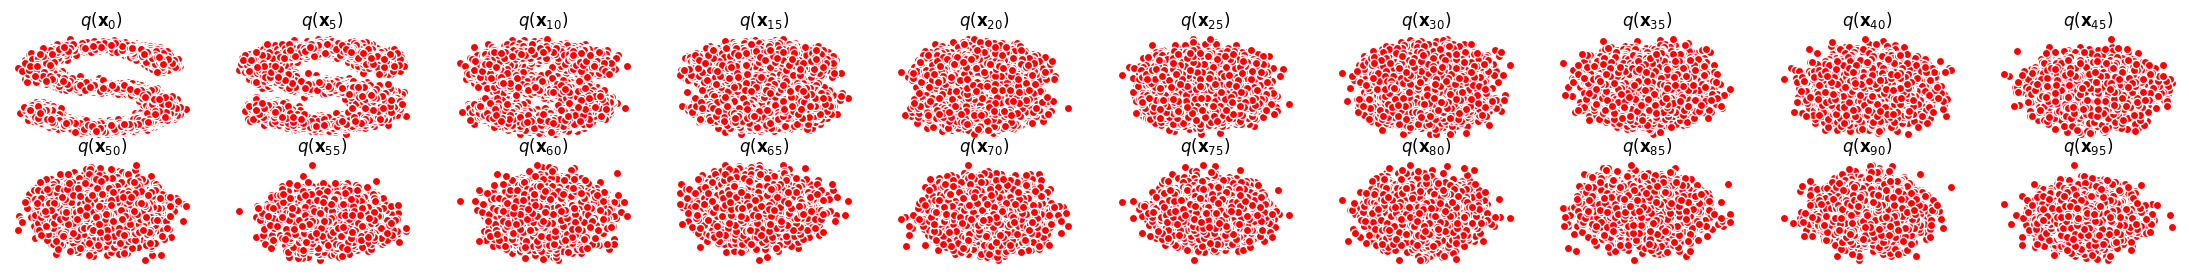

In [7]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

#共有10000个点，每个点包含两个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))#生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

5、编写拟合逆扩散过程高斯分布的模型

In [8]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
        #  x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x
# nn.Embedding：https://blog.csdn.net/qq_39540454/article/details/115215056
# 使用示例：输出维度是2，输入是x和step
# model = MLPDiffusion(num_steps)
# output = model(x,step)

6、编写训练的误差函数

model = MLPDiffusion(num_steps)

x_0: batch_x,部分x_0

alphas_bar_sqrt：$\sqrt{\overline{\alpha_t}}$

one_minus_alphas_bar_sqrt：$\sqrt{1-\overline{\alpha_t}}$

n_steps: num_steps = 100

loss = diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps)

In [10]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t,t的形状是torch.Size([batchsize, 1])
    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t] # torch.Size([batchsize, 1])
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t] # torch.Size([batchsize, 1])
    
    #生成随机噪音eps
    e = torch.randn_like(x_0) # torch.Size([batchsize, 2])
    
    #构造模型的输入
    x = x_0*a+e*aml # torch.Size([batchsize, 2])
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x,t.squeeze(-1)) #t.squeeze(-1)为torch.Size([batchsize])
    # output:torch.Size([batchsize, 2])
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

7、编写逆扩散采样函数（inference）

多次调用def p_sample进行逆扩散，并且保存每次的结果

In [11]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0],x_seq由x[T]、x[T-1]、x[T-2]|...x[0]组成"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

$$
\begin{aligned}
\tilde{\boldsymbol{\mu}}_{t} &=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \mathbf{z}_{t}\right) \\

\mathbf{x}_{t-1} &= \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z}
\end{aligned}
$$
其中，$z_t=z_t={\epsilon}_\theta\left(\mathbf{x}_t, t\right)$由model(x,t)得

In [13]:
def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

8、开始训练模型，打印loss及中间重构效果

Training model...
tensor(0.5495, grad_fn=<MeanBackward0>)
tensor(0.2672, grad_fn=<MeanBackward0>)
tensor(0.6479, grad_fn=<MeanBackward0>)
tensor(0.3458, grad_fn=<MeanBackward0>)
tensor(0.1329, grad_fn=<MeanBackward0>)
tensor(0.5998, grad_fn=<MeanBackward0>)
tensor(0.2975, grad_fn=<MeanBackward0>)
tensor(0.1497, grad_fn=<MeanBackward0>)
tensor(0.3312, grad_fn=<MeanBackward0>)
tensor(0.3732, grad_fn=<MeanBackward0>)
tensor(0.3727, grad_fn=<MeanBackward0>)
tensor(0.4644, grad_fn=<MeanBackward0>)
tensor(0.3448, grad_fn=<MeanBackward0>)
tensor(0.2668, grad_fn=<MeanBackward0>)
tensor(0.4554, grad_fn=<MeanBackward0>)
tensor(0.2827, grad_fn=<MeanBackward0>)
tensor(0.2386, grad_fn=<MeanBackward0>)
tensor(0.1883, grad_fn=<MeanBackward0>)
tensor(0.4977, grad_fn=<MeanBackward0>)
tensor(0.3584, grad_fn=<MeanBackward0>)
tensor(0.1607, grad_fn=<MeanBackward0>)


/tmp/ipykernel_2997/2679162651.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.1955, grad_fn=<MeanBackward0>)
tensor(0.2196, grad_fn=<MeanBackward0>)
tensor(0.1514, grad_fn=<MeanBackward0>)
tensor(0.4604, grad_fn=<MeanBackward0>)
tensor(0.2625, grad_fn=<MeanBackward0>)
tensor(0.2753, grad_fn=<MeanBackward0>)
tensor(0.6264, grad_fn=<MeanBackward0>)
tensor(0.1823, grad_fn=<MeanBackward0>)
tensor(0.4554, grad_fn=<MeanBackward0>)
tensor(0.3188, grad_fn=<MeanBackward0>)
tensor(0.4033, grad_fn=<MeanBackward0>)
tensor(0.4057, grad_fn=<MeanBackward0>)
tensor(0.2514, grad_fn=<MeanBackward0>)
tensor(0.5552, grad_fn=<MeanBackward0>)
tensor(0.1528, grad_fn=<MeanBackward0>)
tensor(0.4485, grad_fn=<MeanBackward0>)
tensor(0.3486, grad_fn=<MeanBackward0>)
tensor(0.3705, grad_fn=<MeanBackward0>)
tensor(0.2614, grad_fn=<MeanBackward0>)


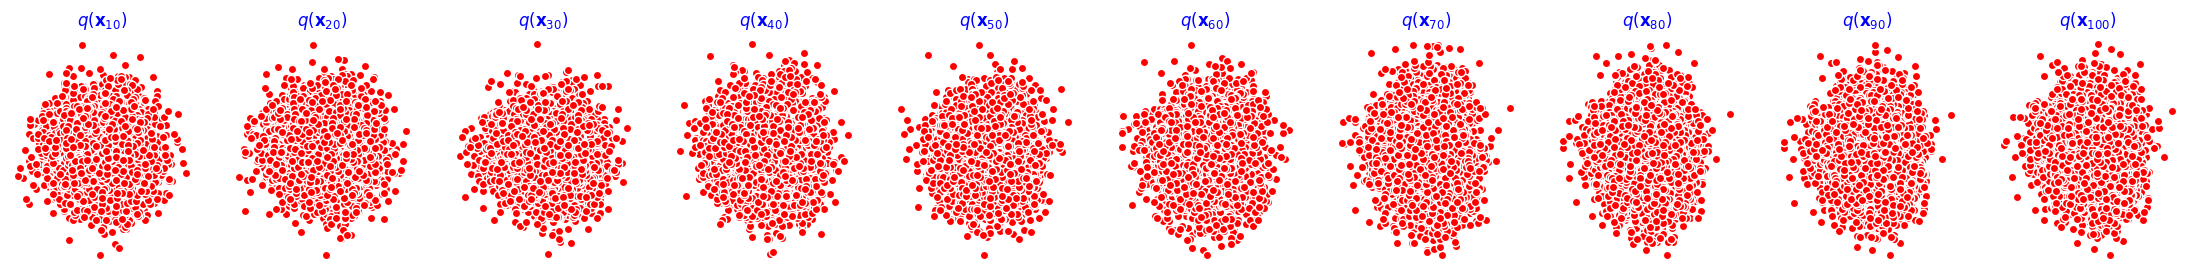

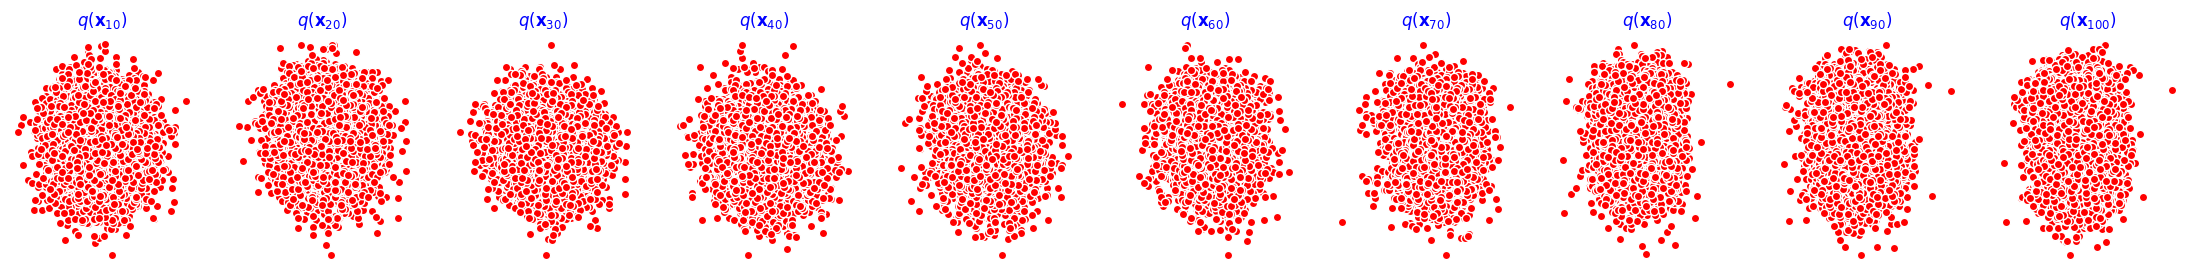

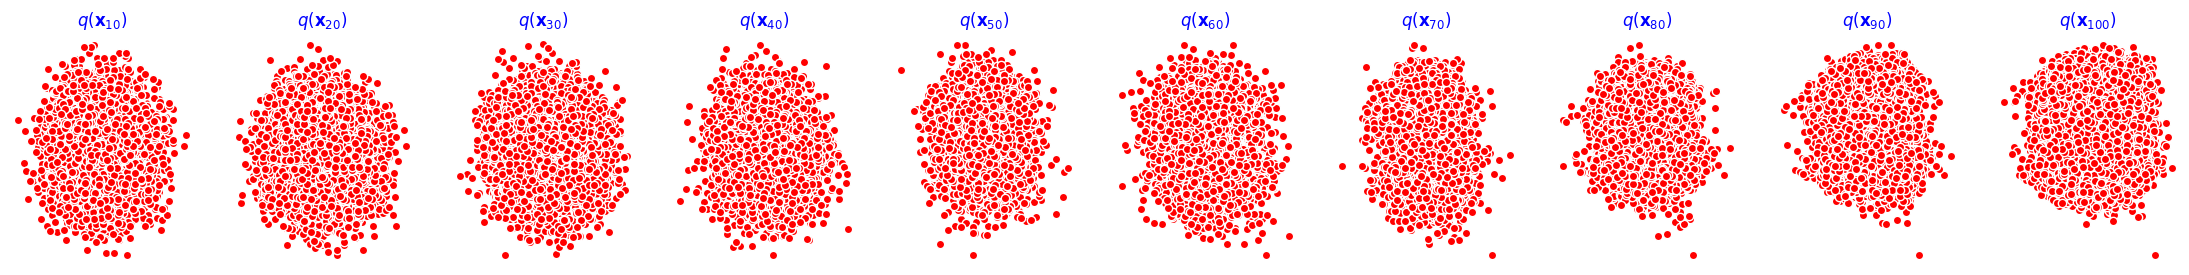

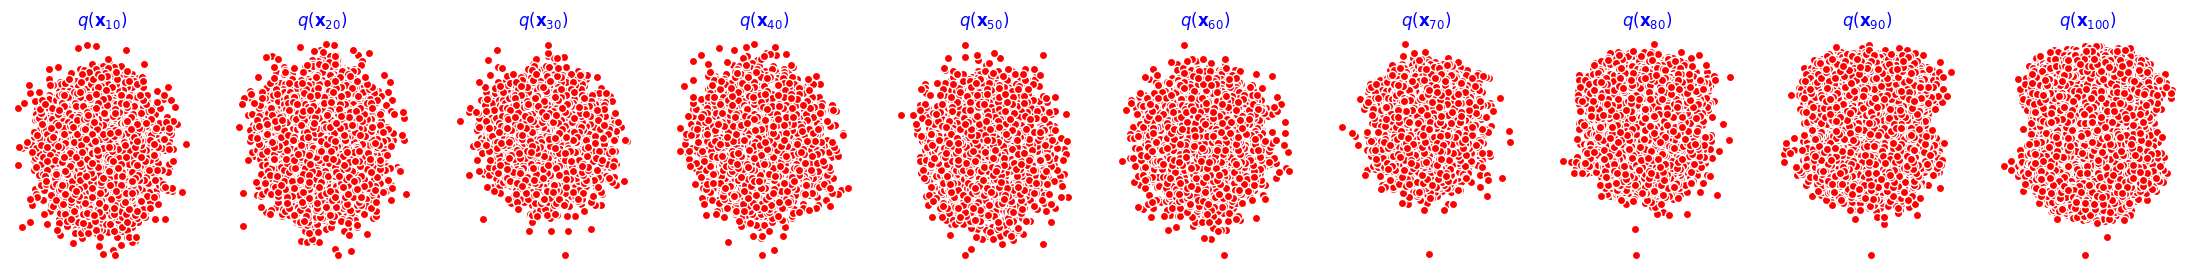

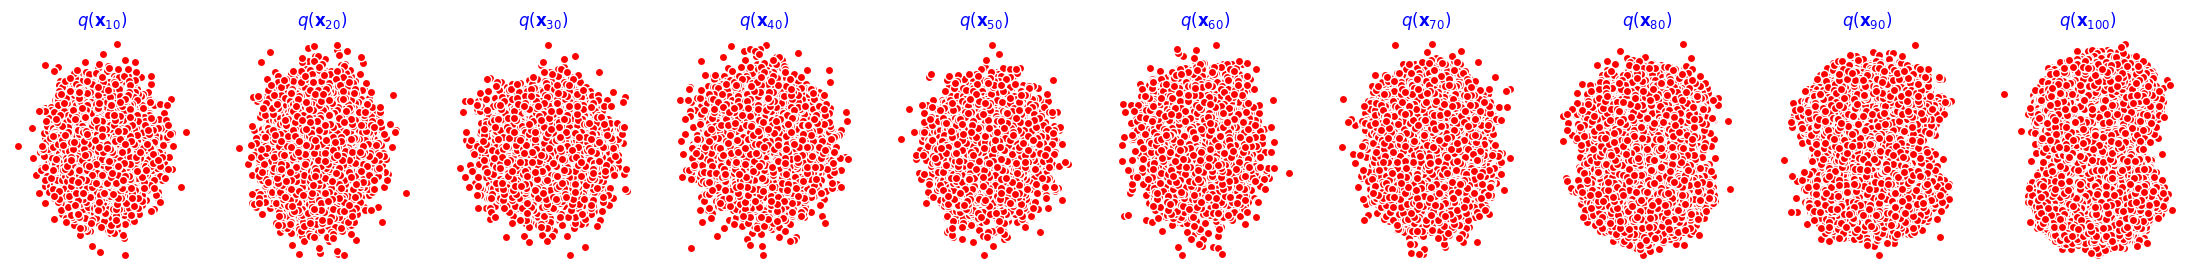

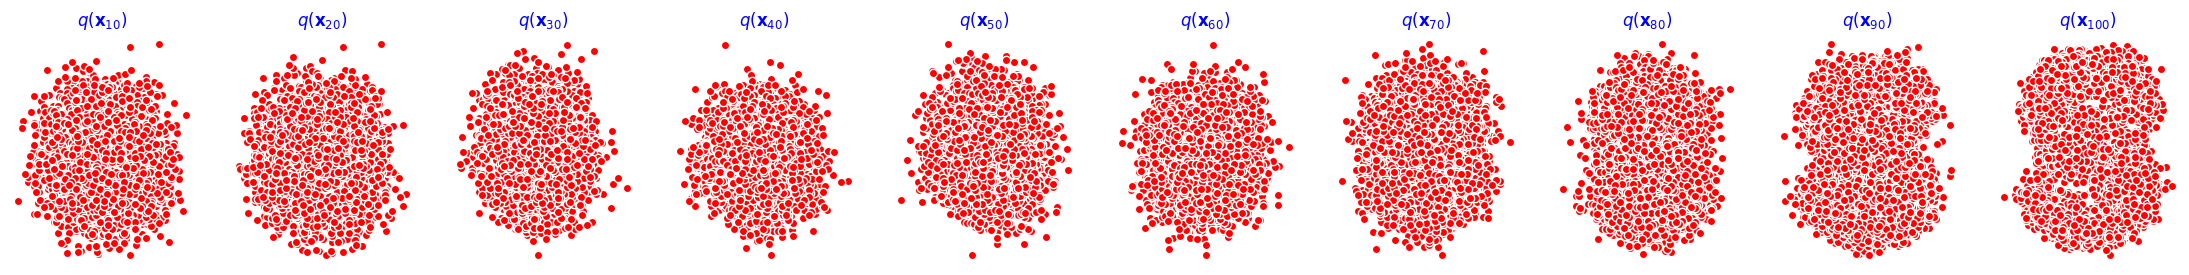

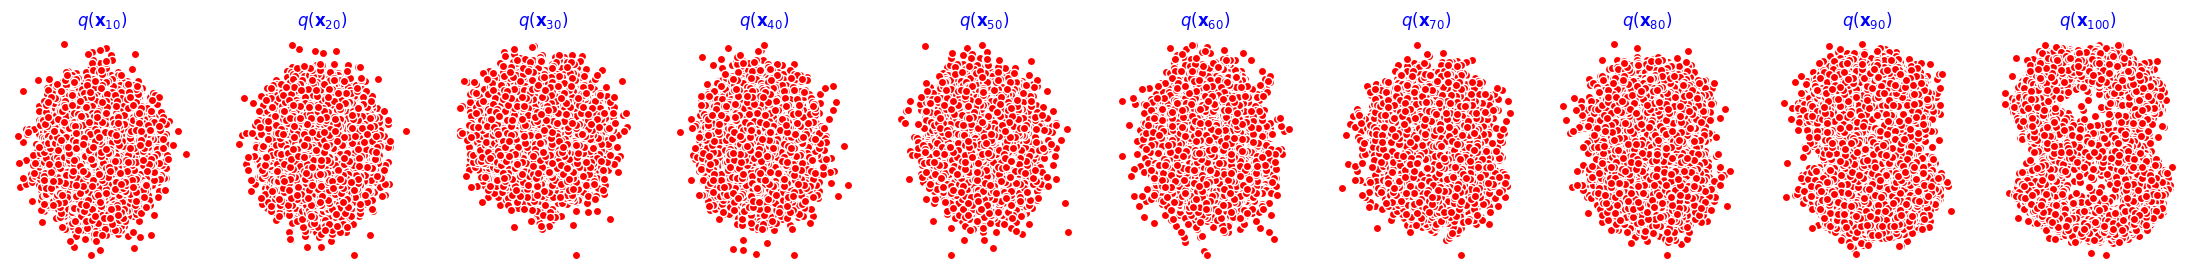

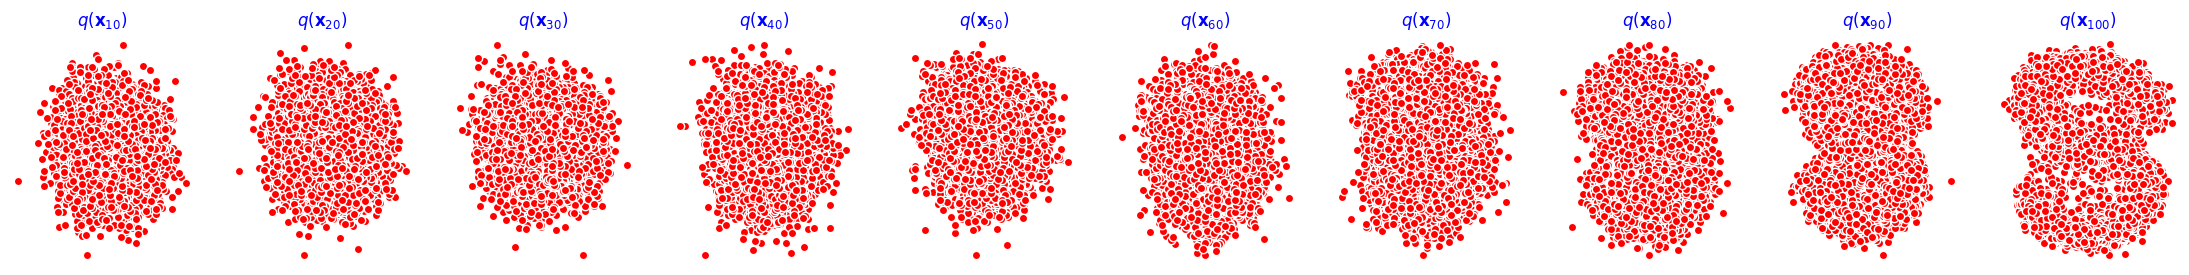

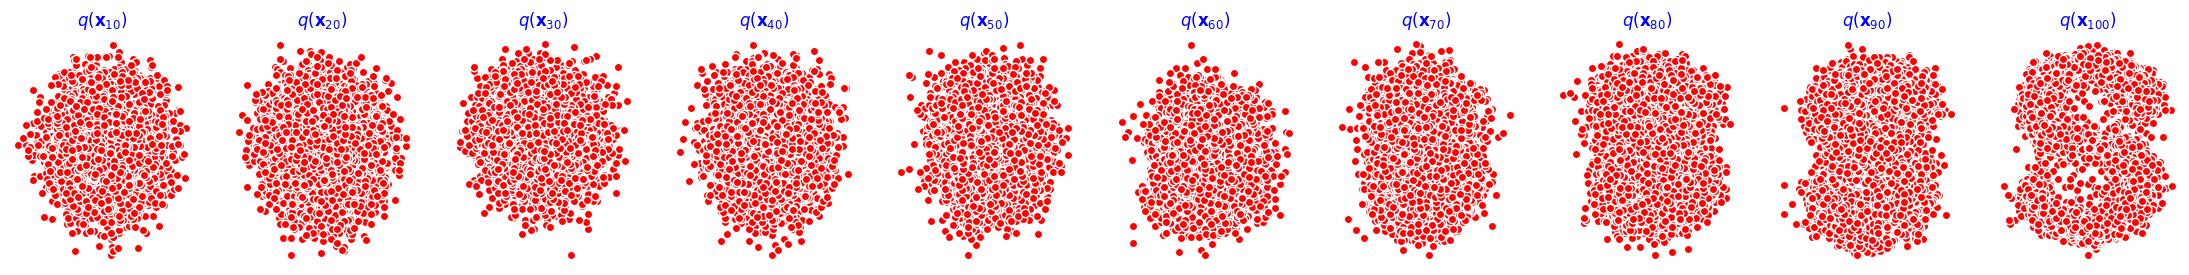

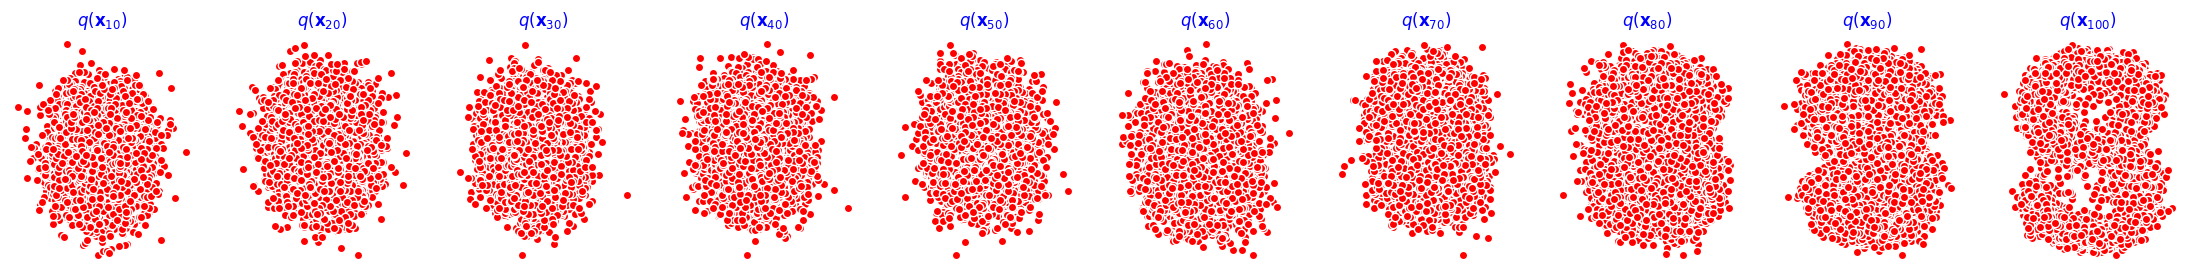

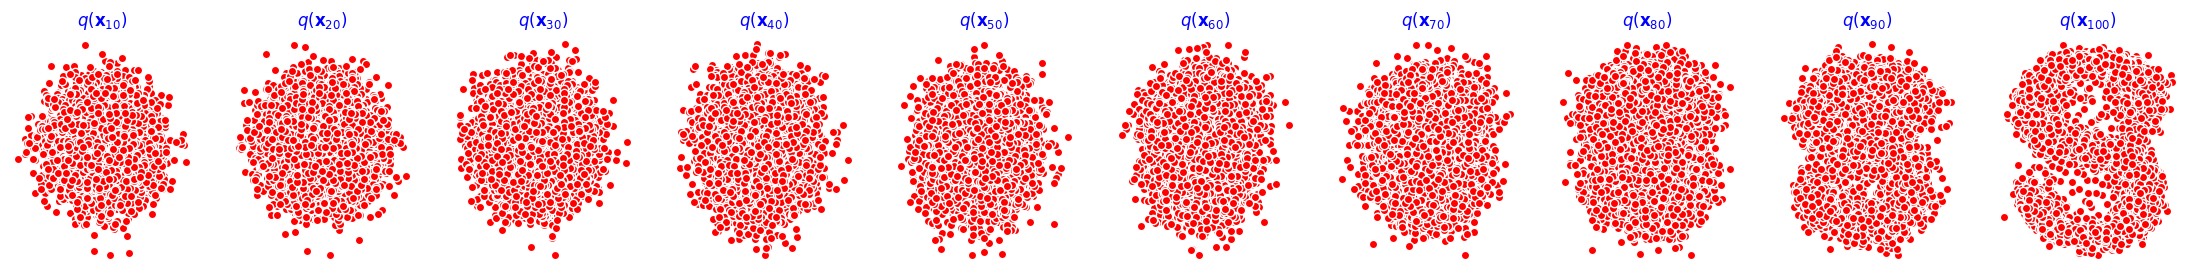

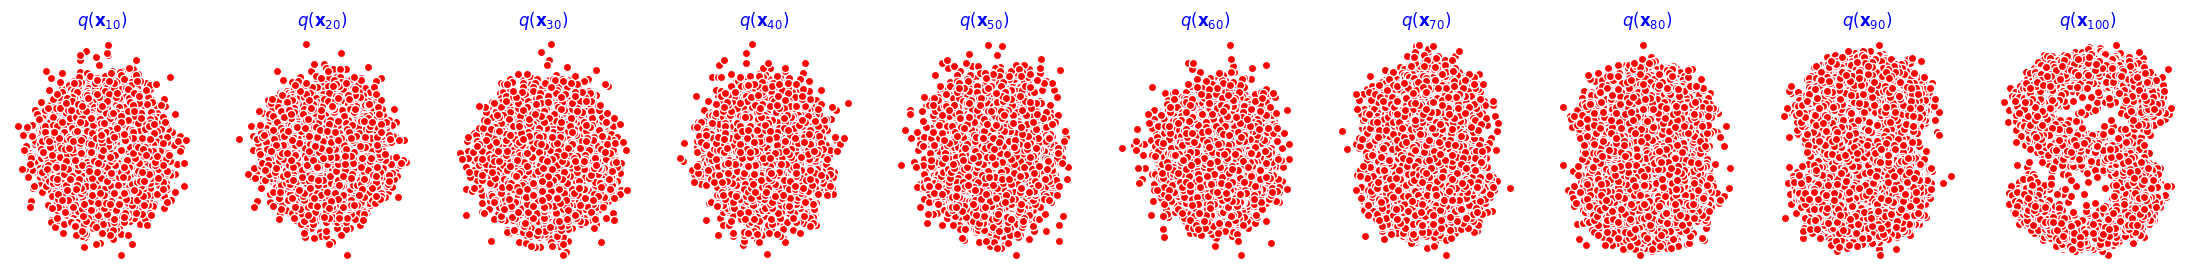

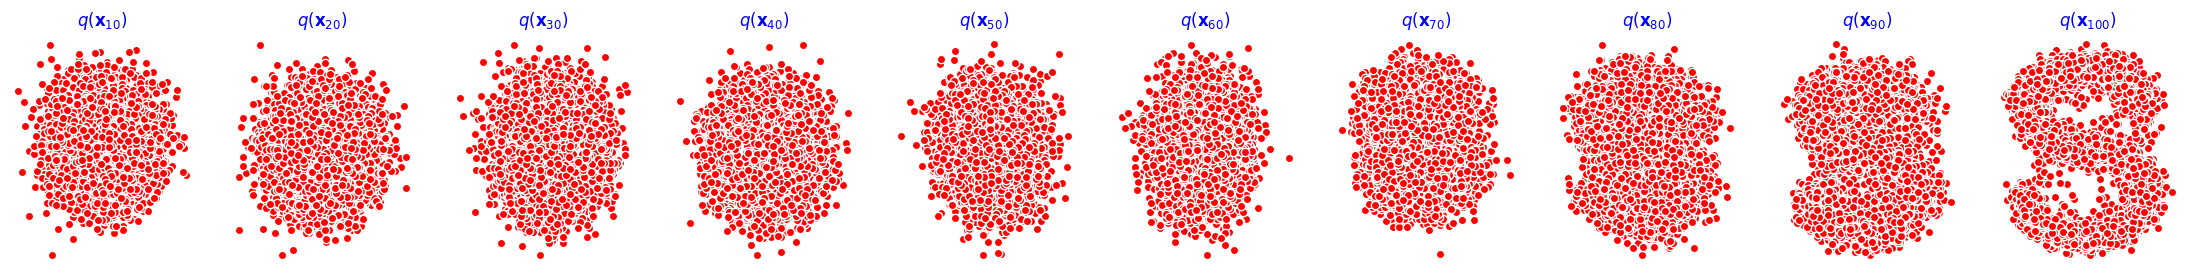

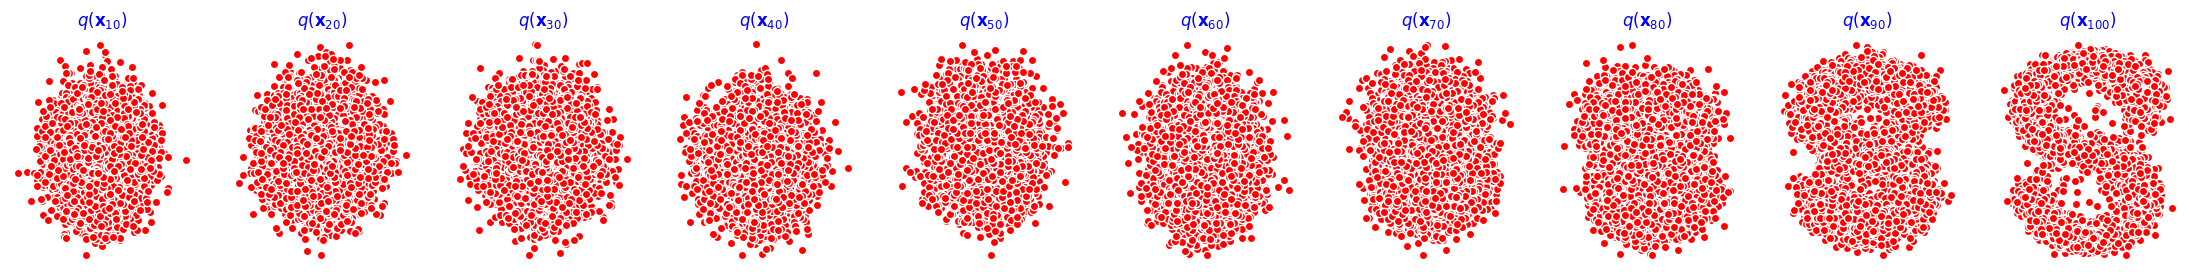

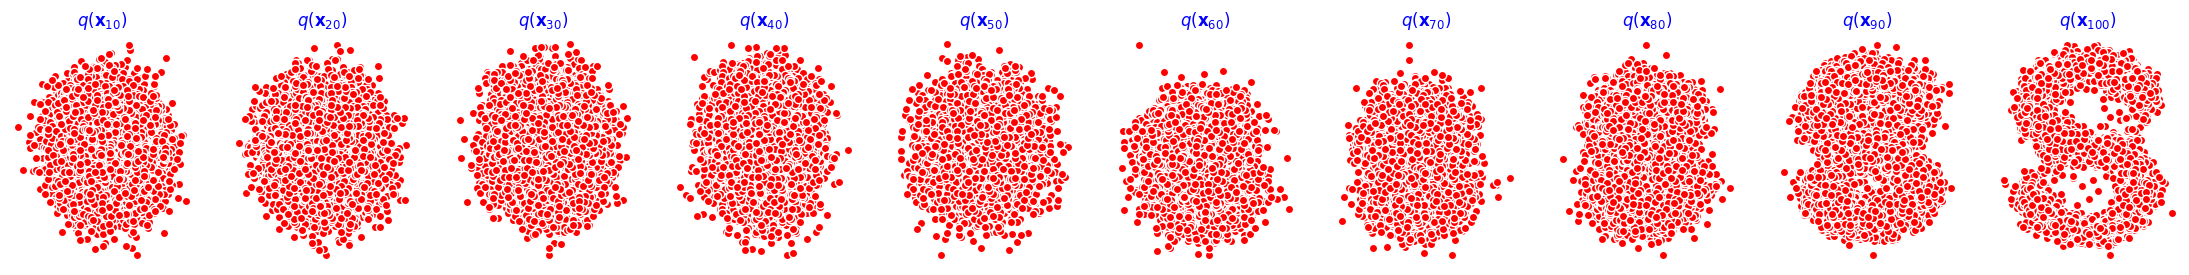

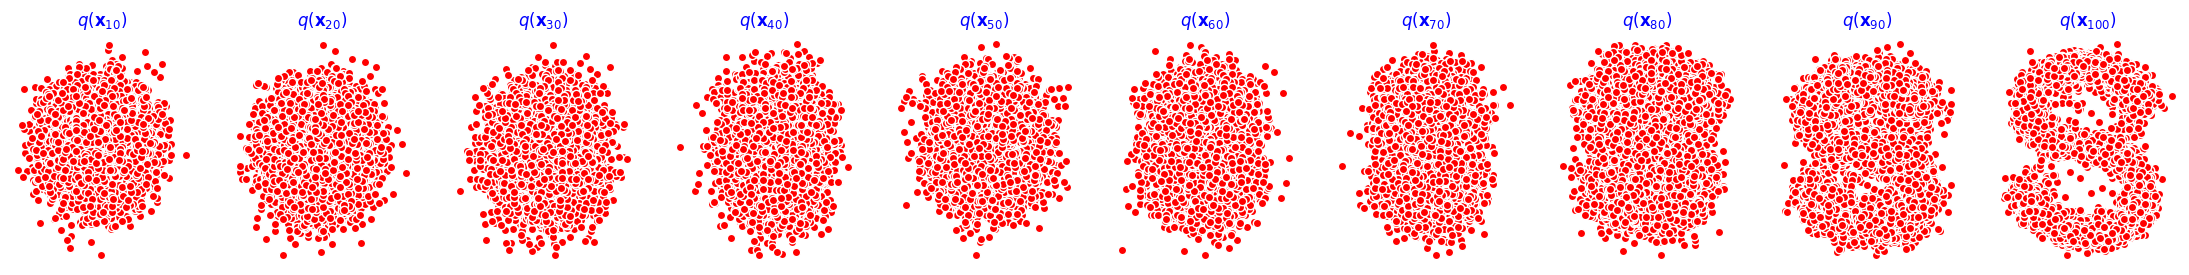

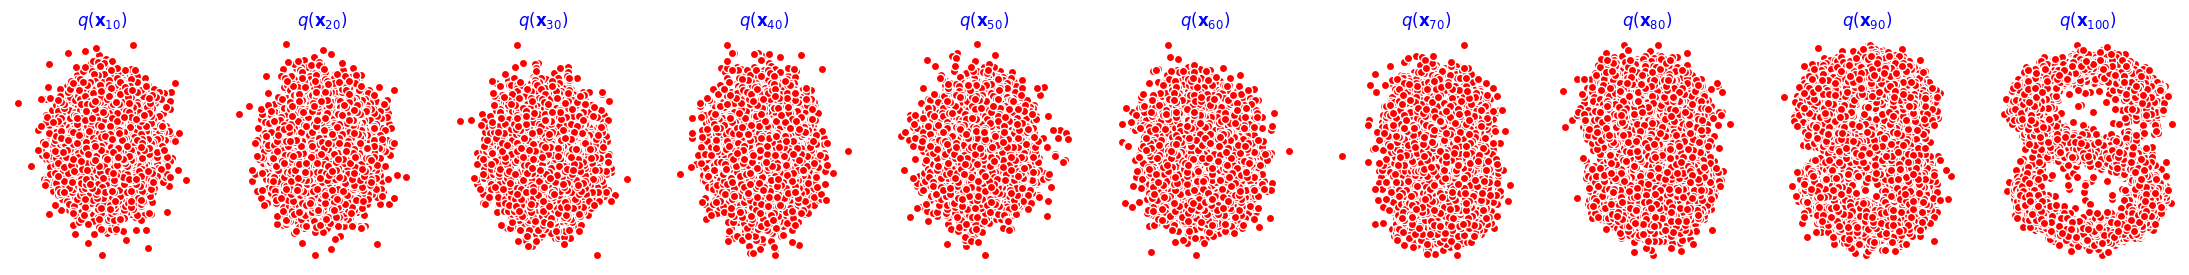

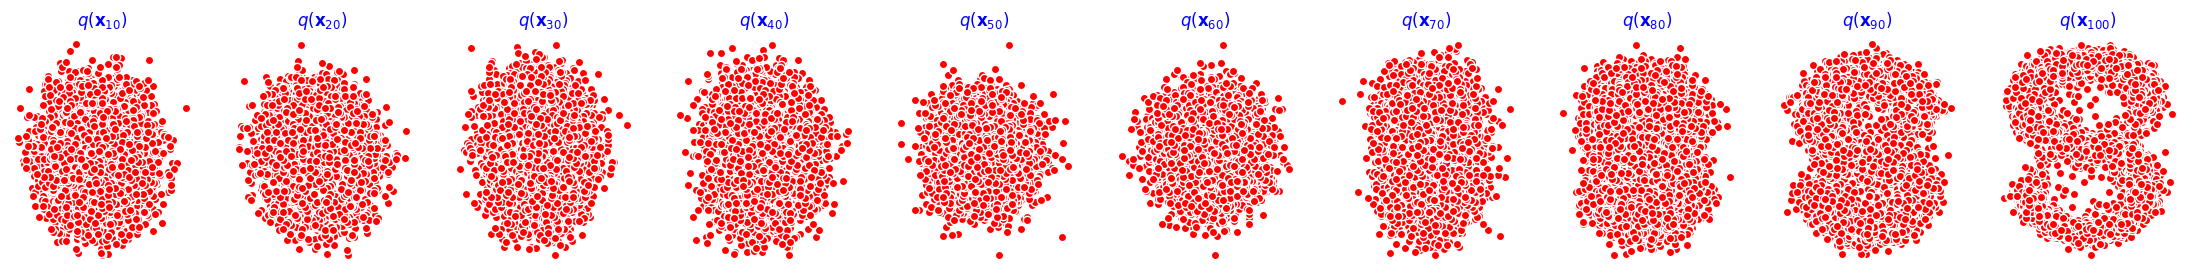

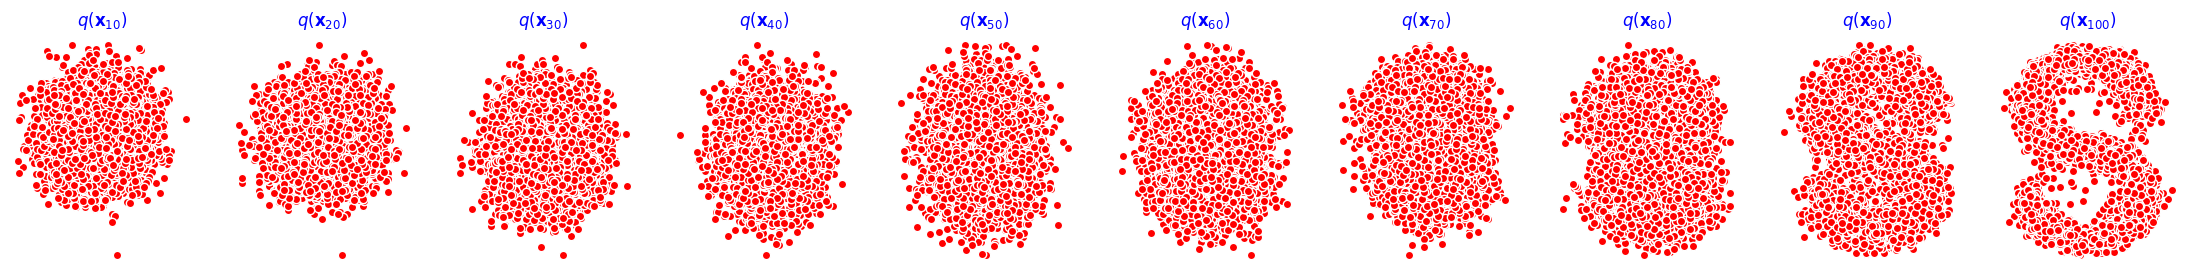

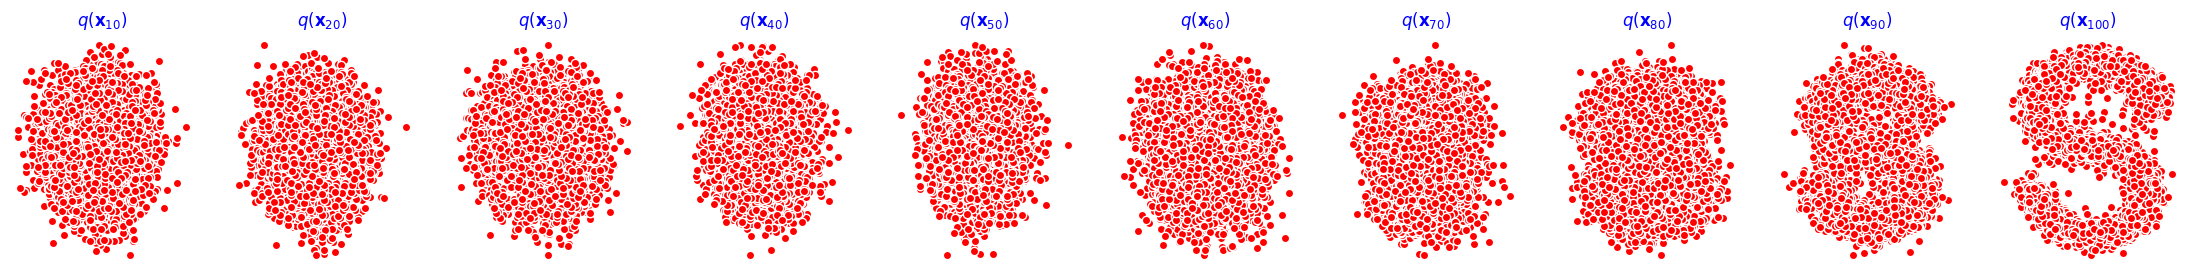

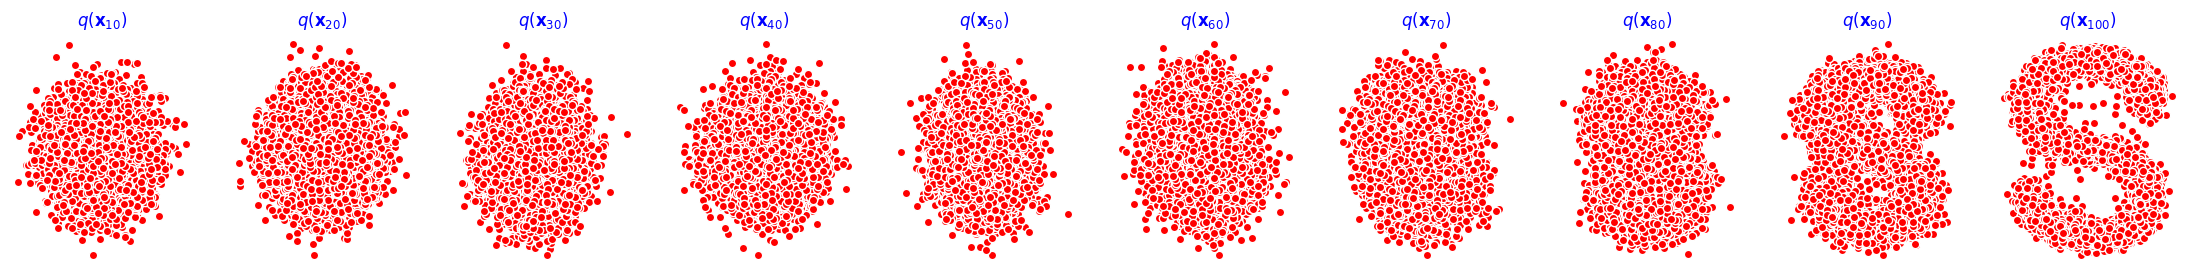

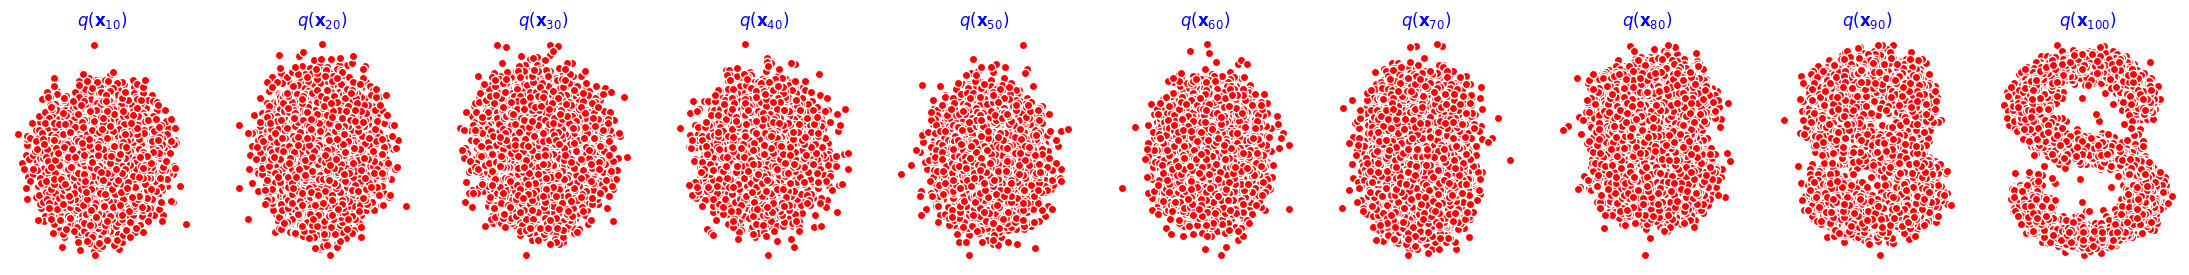

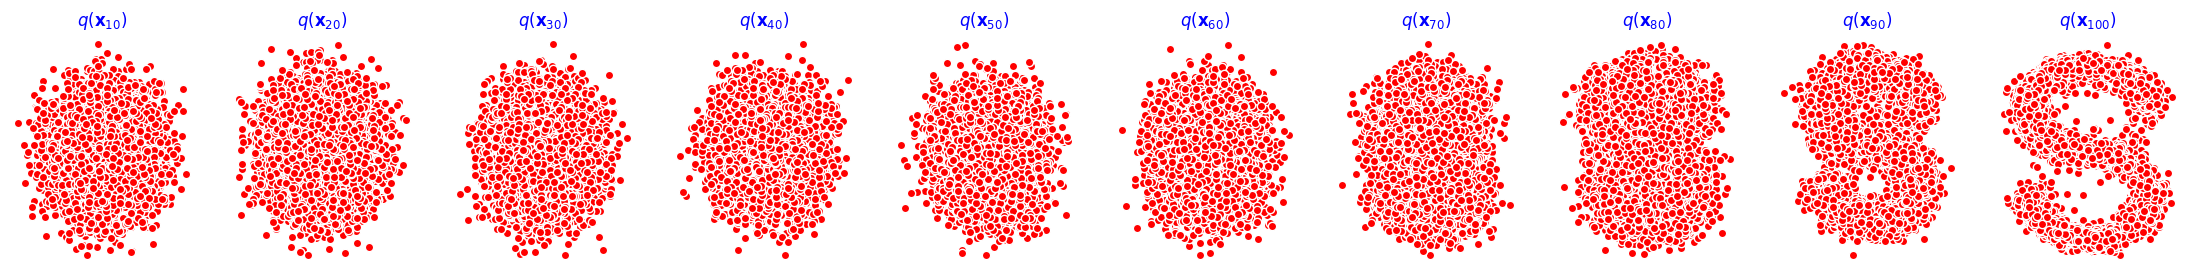

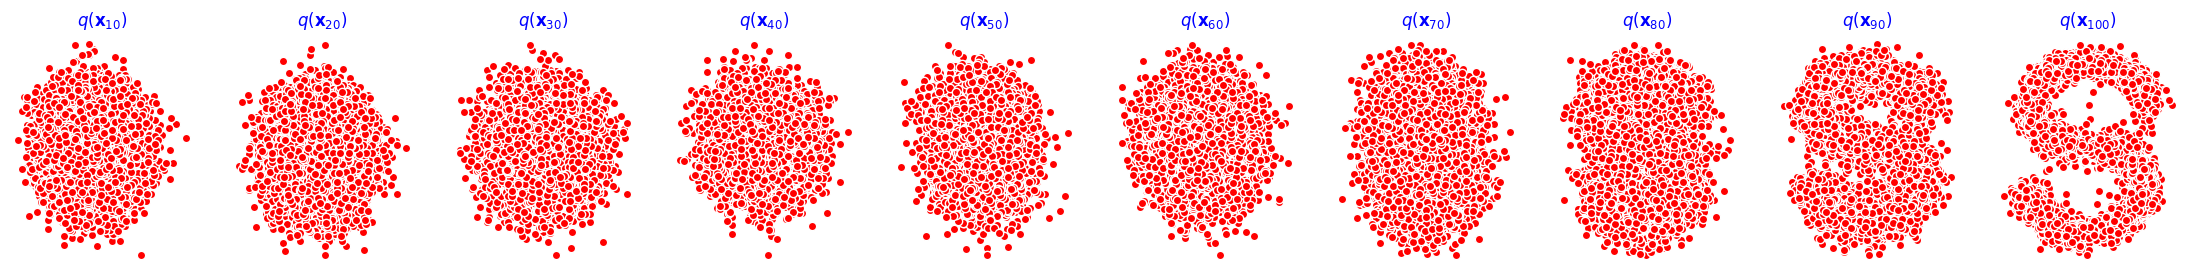

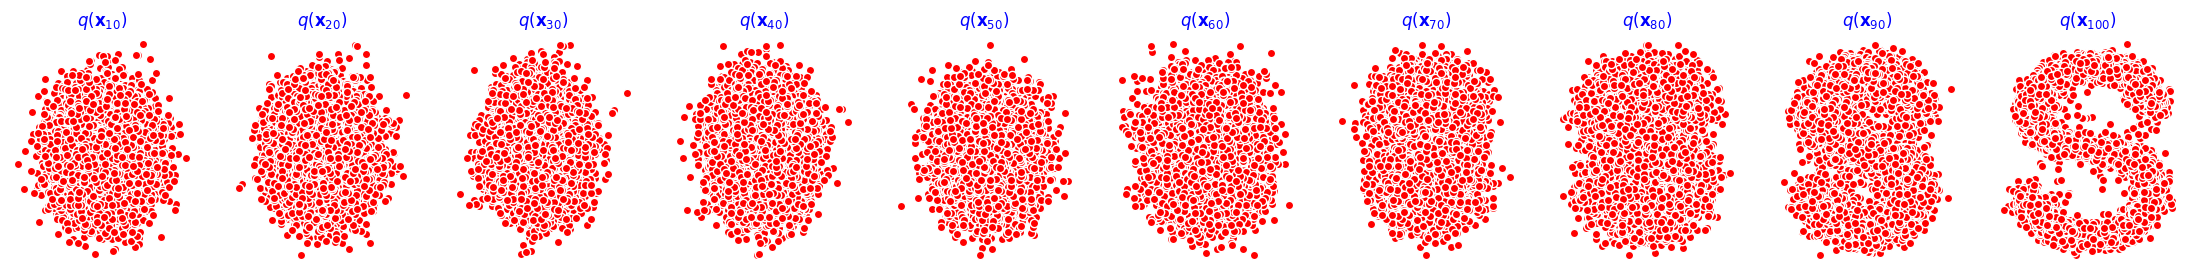

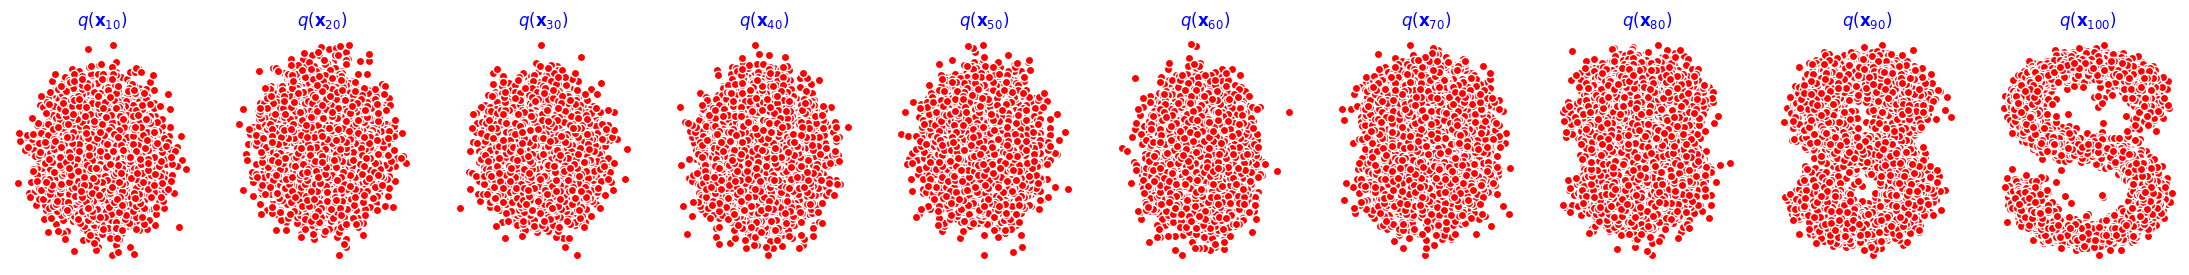

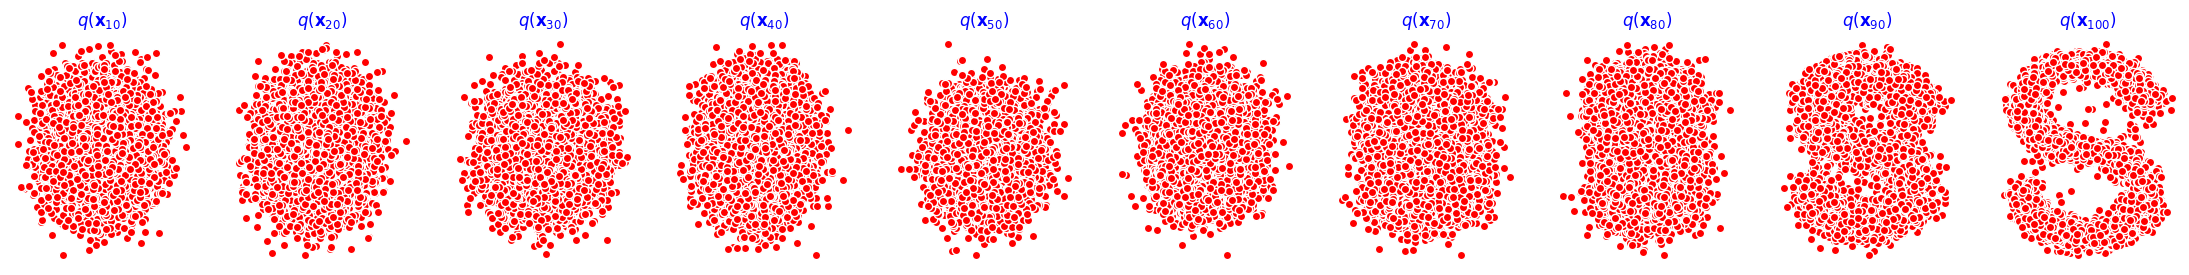

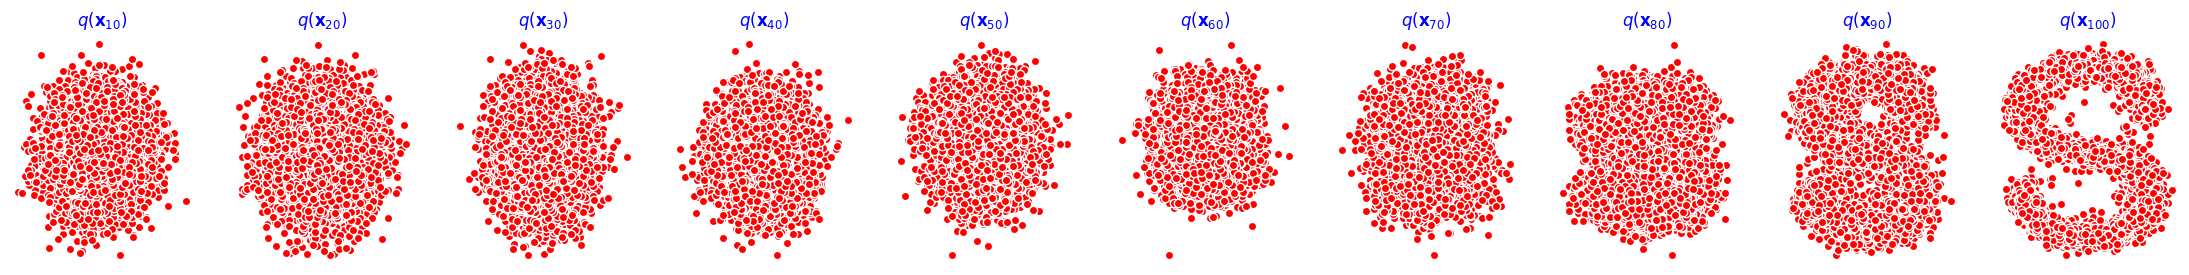

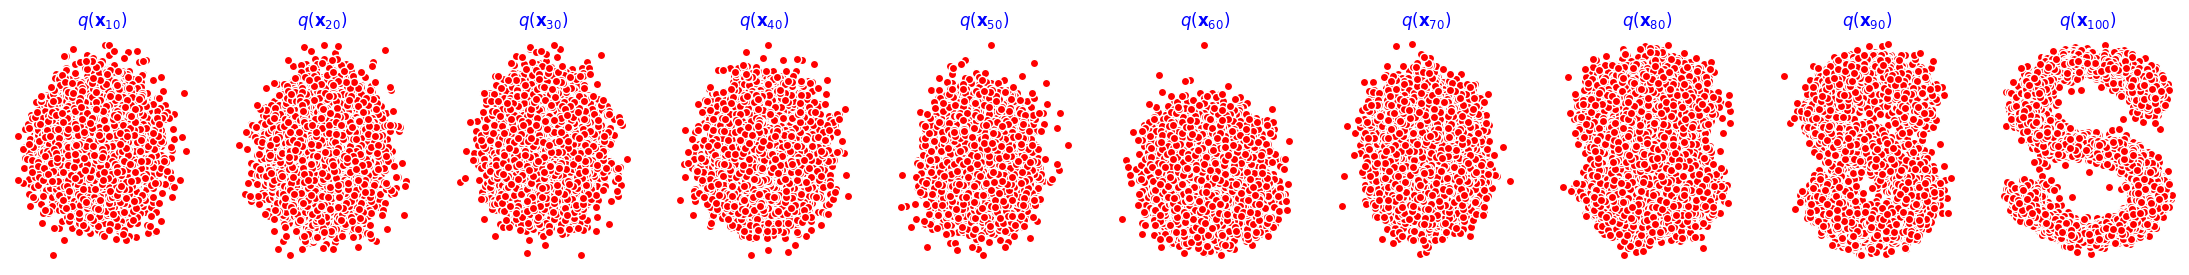

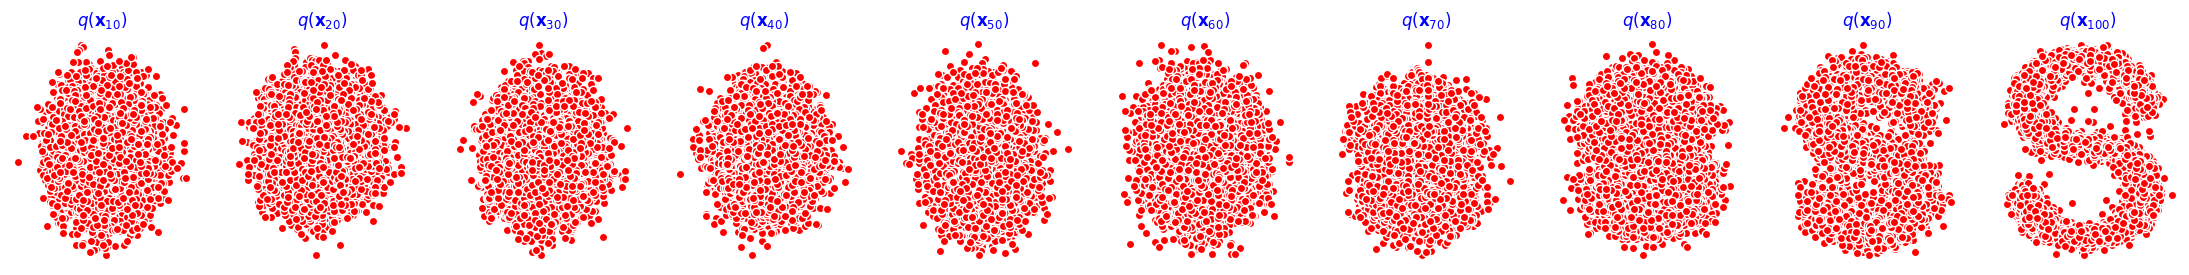

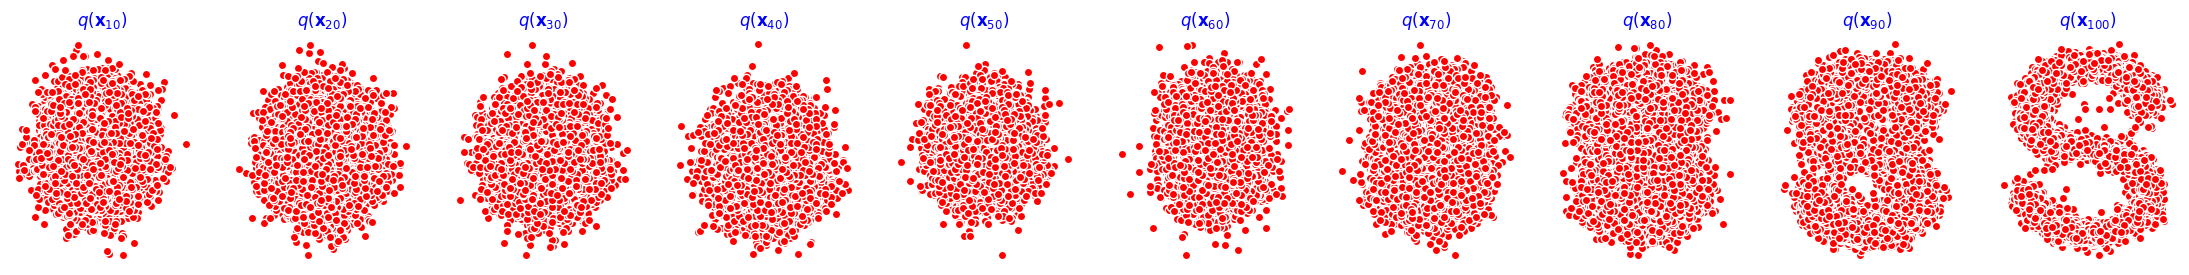

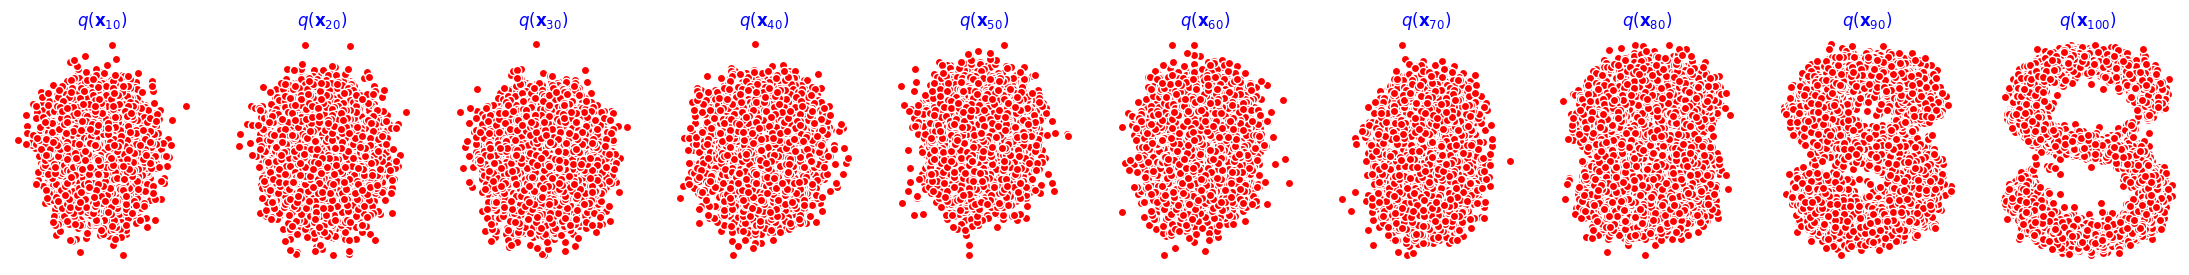

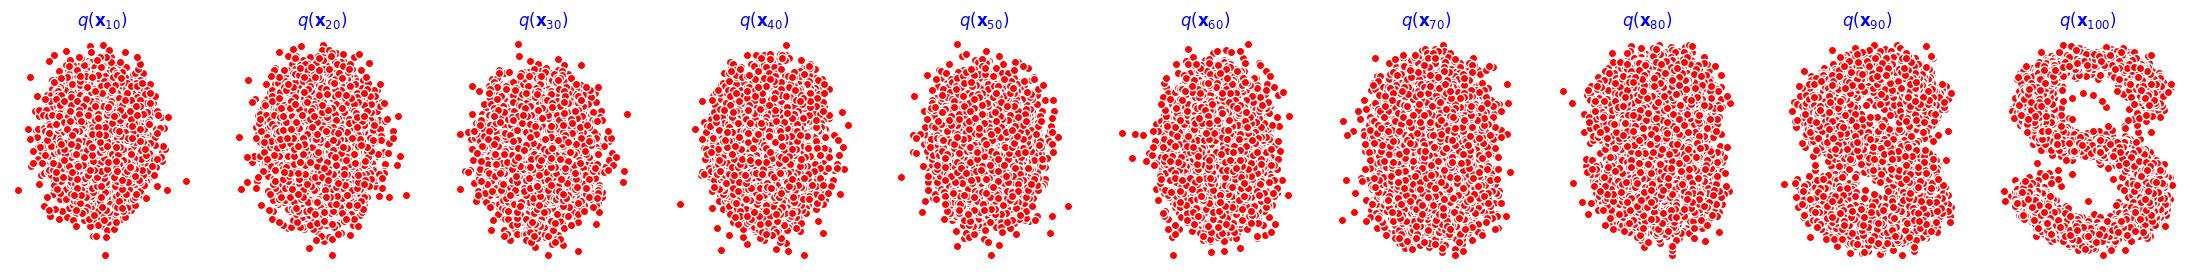

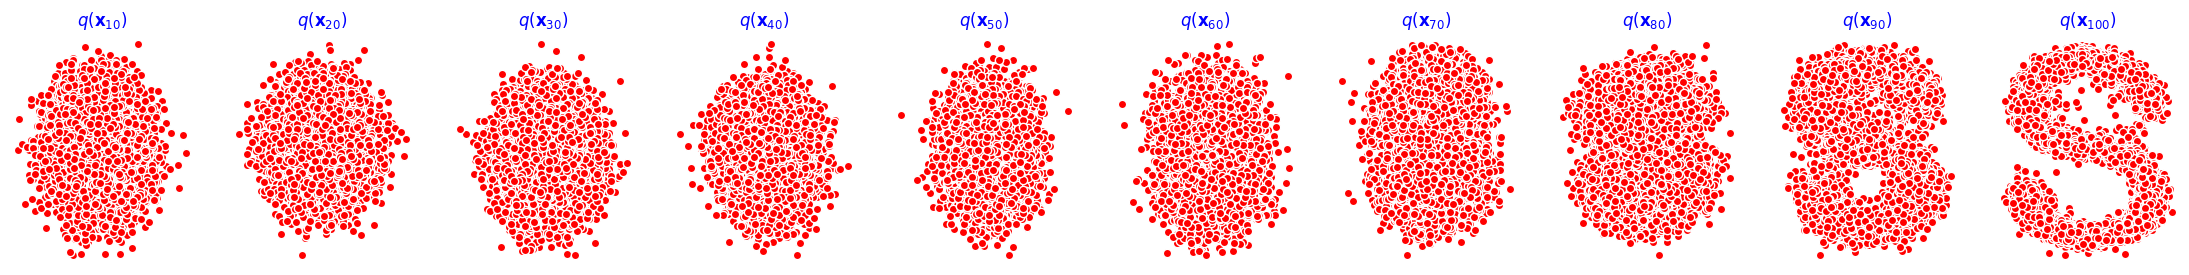

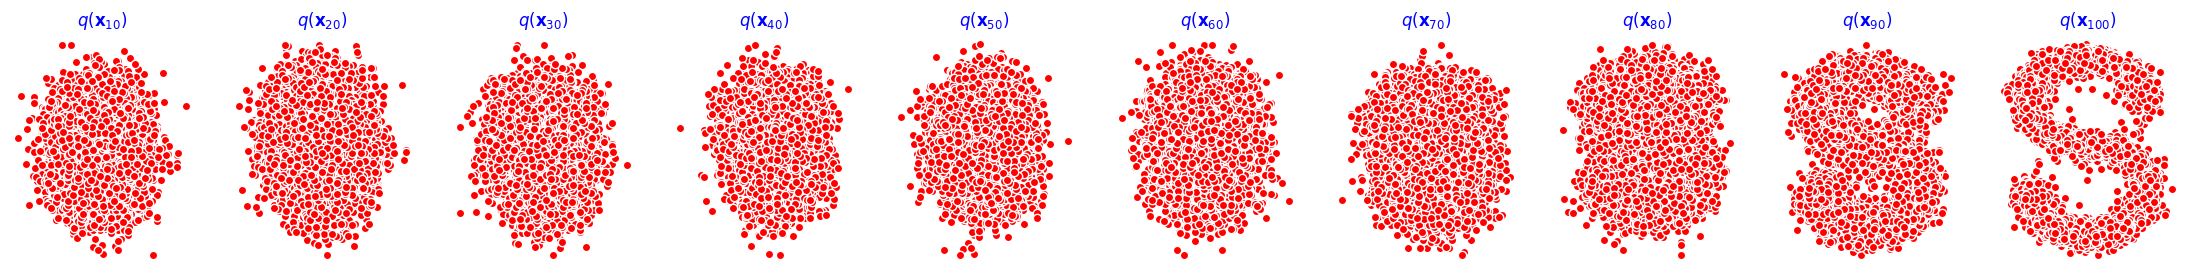

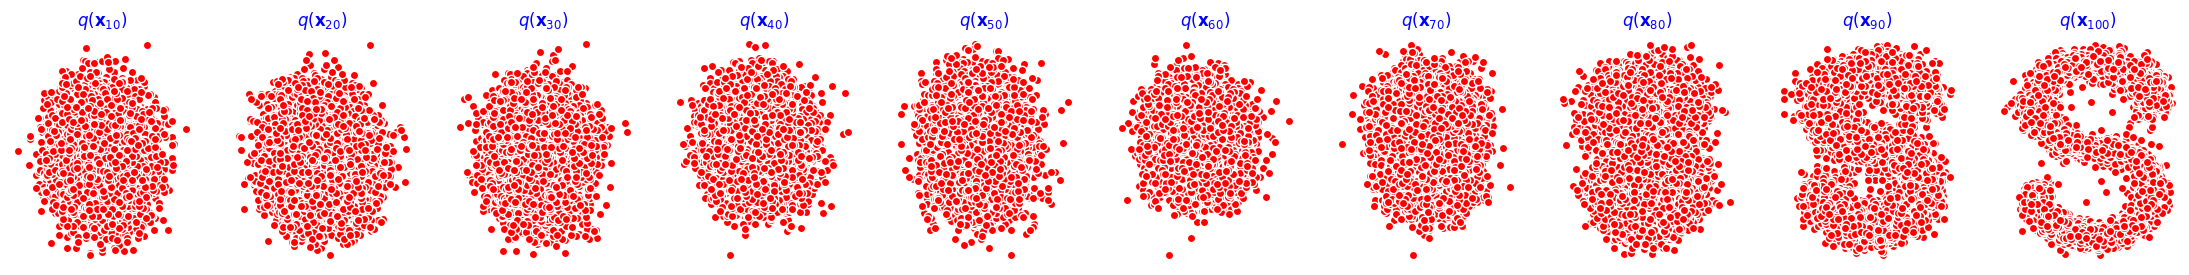

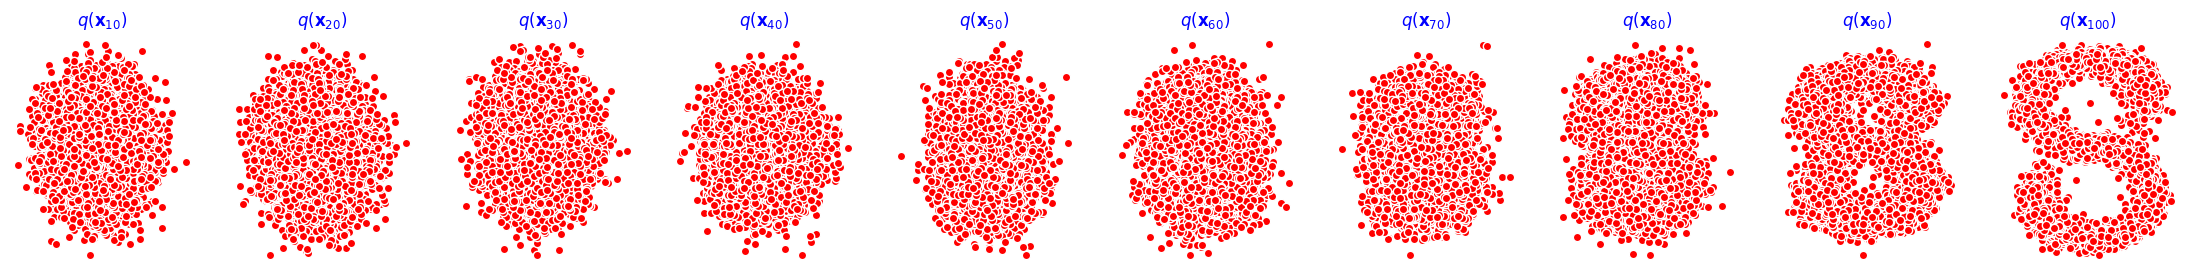

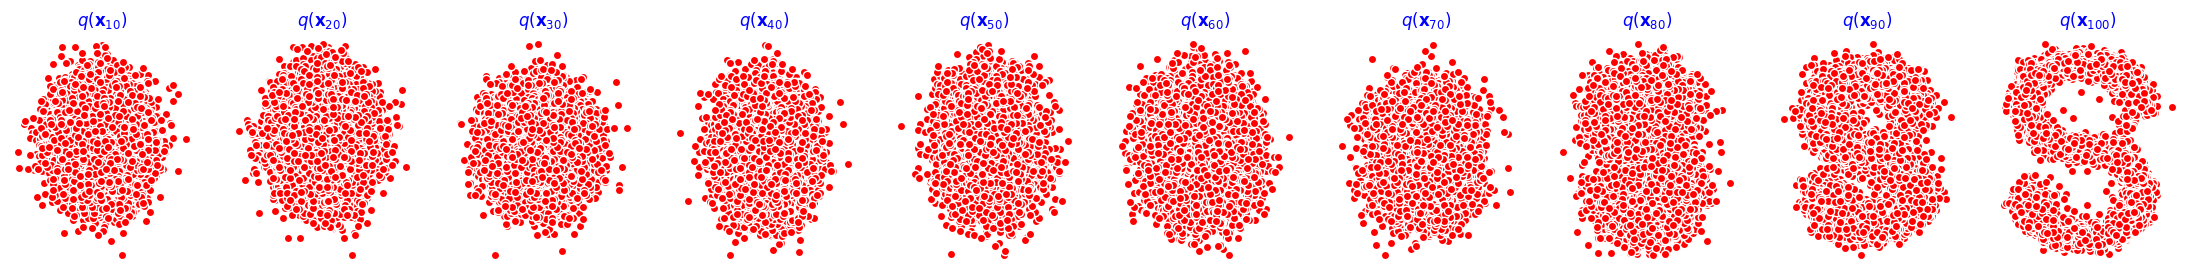

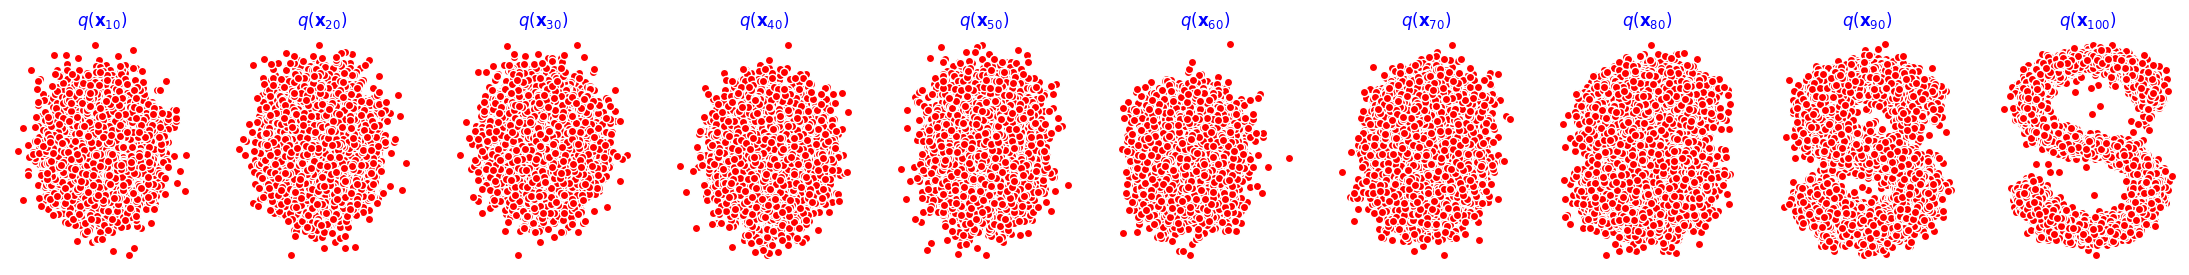

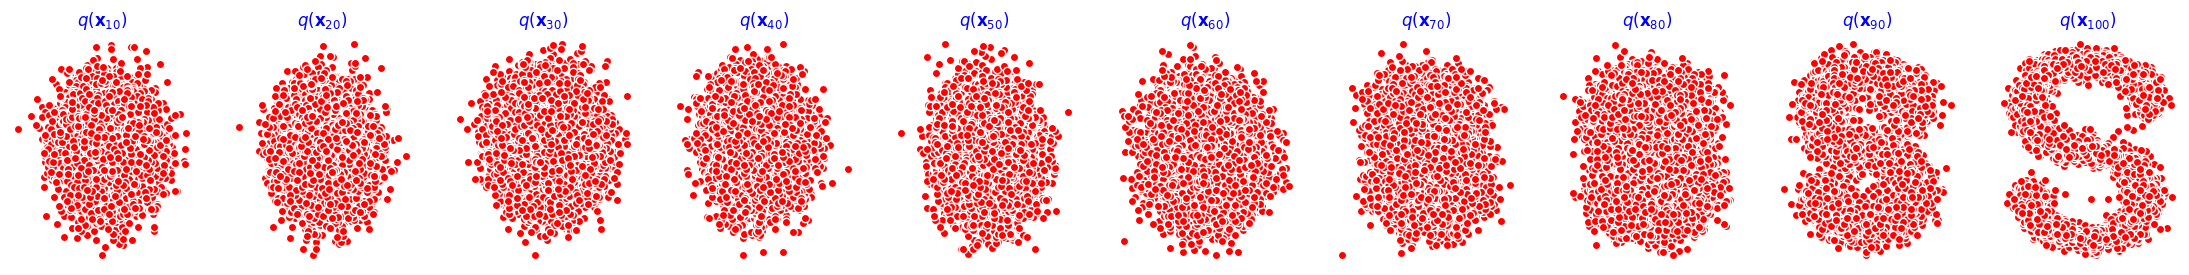

In [14]:
seed = 1234
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

9、动画演示扩散过程和逆扩散过程

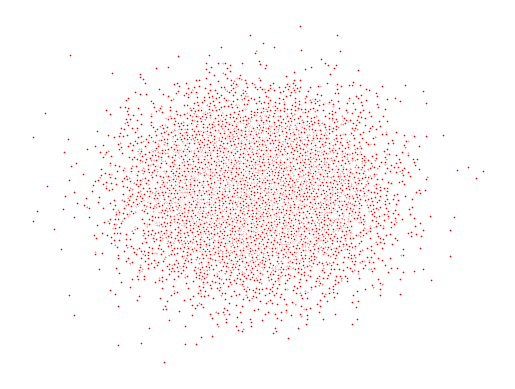

In [15]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset,torch.tensor([i]))
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

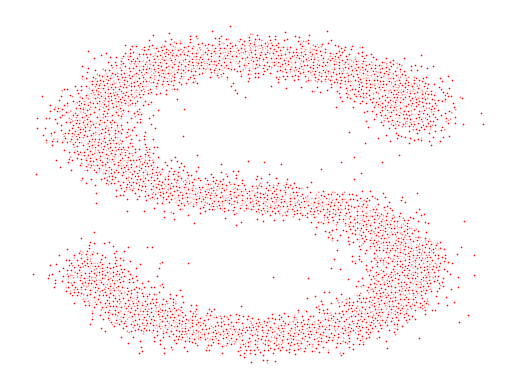

In [16]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [17]:
imgs = imgs +reverse

In [18]:
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)